<a href="https://colab.research.google.com/github/lmbibbo/aiInvest/blob/main/Makemore_IA_invest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías


In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta

access_token = '1713e3a380561bc6cc72bfcf2ba86e0f4de82421'

def load_especie(especie, access_token):
    url = 'https://clasico.rava.com/lib/restapi/v3/publico/cotizaciones/historicos'
    fecha_fin = datetime.today().date()
    fecha_inicio = fecha_fin - timedelta(days=500)
    fecha_fin_yyyymmdd = fecha_fin.strftime('%Y-%m-%d')
    fecha_inicio_yyyymmdd = fecha_inicio.strftime('%Y-%m-%d')

    data = {}
    data["access_token"] = access_token
    data["especie"] = especie
    data["fecha_inicio"] = fecha_inicio_yyyymmdd
    data["fecha_fin"] = fecha_fin_yyyymmdd
    response = requests.post(url, data=data)
    if response.status_code == 200:
        # Guardar el contenido de la respuesta en un archivo
        data_json = response.json()
        body = data_json.get('body', None)
        if body:
            df = pd.DataFrame(body)
            df = convertir_rava(df)
        else:
            print("Error: No se encuentra el body del archivo.")
        print("Archivo descargado exitosamente.")
    else:
        print("Error al descargar el archivo:", response.status_code)
    return df

In [2]:
def recortar(df, dias):
#    df = df.set_index('FECHA')
    df = df.sort_values(by=['FECHA'])
#    df = df.tail(dias)
#    df = df.reset_index()
    df = df.iloc[-dias:]
    df = normalizar(df)

    return df

In [3]:
def read_data(file):
    filas = 3650
    df = pd.read_csv(file, skiprows=lambda x: x != 0 and x < (filas * -1))
    return df

def clasificar(simbolo):
    if simbolo in ['BBAR', 'BMA', 'VALO', 'SUPV', 'GGAL']:
        return 'BANCOS'
    elif simbolo in ['ALUA', 'LOMA', 'TXAR']:
        return 'CONSTRUCCION'
    elif simbolo in ['CEPU', 'EDN', 'PAMP', 'TGNO4', 'TGSU2', 'TRAN', 'YPFD']:
        return 'ENERGIA'
    elif simbolo in ['COME', 'MIRG', 'BYMA']:
        return 'COMERCIO'
    elif simbolo in ['AGRO', 'CRES']:
        return 'AGRO'
    elif simbolo in ['TECO2']:
        return 'TELECOMUNICACIONES'
    else:
        return 'Desconocido'


def convertir_rava(df):
    df.columns = df.columns.str.upper()
    #df.drop(['VARMTD', 'VARYTD', 'VAR6M', 'VAR12M', 'HORA', 'TIMESTAMP'], axis=1)
    df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y-%m-%d')
    df['CIERRE'] = df['CIERRE'].astype(float)
    df['APERTURA'] = df['APERTURA'].astype(float)
    df['RESULTADO'] = df['CIERRE'] - df['APERTURA']
    df['PORCENTAJE'] = ((df['CIERRE'] - df['APERTURA']) / df['APERTURA'])
    #df['CIERRE1'] = df['CIERRE'].shift(-1)
    #df['CIERRE3'] = df['CIERRE'].shift(-3)
    #df['CIERRE5'] = df['CIERRE'].shift(-5)
    #df['CIERRE9'] = df['CIERRE'].shift(-9)
    #df['TARGET1'] = (df['CIERRE1'] > df['CIERRE']).astype(int)
    #df['TARGET3'] = (df['CIERRE3'] > df['CIERRE1']).astype(int)
    #df['TARGET5'] = (df['CIERRE5'] > df['CIERRE3']).astype(int)
    #df['TARGET9'] = (df['CIERRE9'] > df['CIERRE5']).astype(int)
    df.dropna()
    return df


def convertir(df):
    df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y-%m-%d')
    df['CIERRE'] = df['CIERRE'].str.replace(',', '.').astype(float)
    df['APERTURA'] = df['APERTURA'].str.replace(',', '.').astype(float)
    df['MAXIMO'] = df['MAXIMO'].str.replace(',', '.').astype(float)
    df['MINIMO'] = df['MINIMO'].str.replace(',', '.').astype(float)
    df['RESULTADO'] = df['CIERRE'] - df['APERTURA']
    df['PORCENTAJE'] = ((df['CIERRE'] - df['APERTURA']) / df['APERTURA'])
    # df['RES_PESADO'] = df['RESULTADO'] * df['MONTO NEGOCIADO']
    df['CLASE'] = df['SIMBOLO'].apply(clasificar)
    #df['TOMORROW'] = df['CIERRE']-df['CIERRE'].shift(-1)
    return df


def norma_key(df, clave, rango=0):
    v_min = np.min(df[clave])
    v_max = np.max(df[clave])

    #df[clave + '_N'] = (((df[clave] - v_min) * (rango+1)) / (v_max - v_min))-rango # Normalización por rango
    df[clave + '_N'] = ((df[clave] - df[clave].mean()) / df[clave].std()).round(2)  # Normalización por z-score o Gaussian normalization
    return df


def normalizar(df):
    df_ret = pd.DataFrame(df)
    norma_key(df_ret, 'CIERRE', 1)
    #norma_key(df_ret, 'APERTURA', 1)
    #norma_key(df_ret, 'MAXIMO', 1)
    #norma_key(df_ret, 'MINIMO', 1)
    # norma_key(df_ret, 'PRECIO PROMEDIO', 1)
    # norma_key(df_ret, 'VOLUMEN NOMINAL', 1)
    # norma_key(df_ret, 'MONTO NEGOCIADO', 1)
    norma_key(df_ret, 'RESULTADO', 1)
    # norma_key(df_ret, 'RES_PESADO', 1)
    # norma_key(df_ret, 'BULLISH', 0)
    # norma_key(df_ret, 'BEARISH', 0)
    return df_ret

Importamos las librerías

In [4]:
import matplotlib.pyplot as plt

Inicializamos algunas variables


Cargamos los datos

In [5]:
df_dmep_original = load_especie("DOLAR MEP", access_token)
df_djones_original = load_especie("DIA_US", access_token)
df_merval_original = load_especie('MERVAL', access_token)
df_doficial_original = load_especie('DOLAR OFICIAL', access_token)
df_ypfd_original = load_especie('YPFD', access_token)
df_edn_original = load_especie('EDN', access_token)
df_bbar_original = load_especie('BBAR', access_token)

Archivo descargado exitosamente.
Archivo descargado exitosamente.
Archivo descargado exitosamente.
Archivo descargado exitosamente.
Archivo descargado exitosamente.
Archivo descargado exitosamente.
Archivo descargado exitosamente.


In [6]:
dias = 1500
df_ypfd = recortar(df_ypfd_original, dias)
df_dmep = recortar(df_dmep_original, dias)
df_doficial = recortar(df_doficial_original, dias + (int(dias/7)*2))
df_merval = recortar(df_merval_original, dias)
df_djones = recortar(df_djones_original, dias)
df_edn = recortar(df_edn_original, dias)
df_bbar = recortar(df_bbar_original, dias)

In [7]:
df_dmep

,ESPECIE,ULTIMO,VARIACION,ANTERIOR,APERTURA,MINIMO,MAXIMO,VARMTD,VARYTD,VAR6M,VAR12M,FECHA,HORA,CIERRE,TIMESTAMP,VOLUMEN,RESULTADO,PORCENTAJE,CIERRE_N,RESULTADO_N
0,DOLAR MEP,437.75,3.8,421.9,421.90,419.23,445.18,,,,,2023-04-21,19:59,437.75,1682046000,0,15.85,0.037568,-1.56,0.66
1,DOLAR MEP,449.02,2.6,437.75,437.75,429.31,450.53,,,,,2023-04-24,19:59,449.02,1682305200,0,11.27,0.025745,-1.53,0.44
2,DOLAR MEP,447.5,-0.3,449.02,449.02,446.99,471.69,,,,,2023-04-25,19:59,447.50,1682391600,0,-1.52,-0.003385,-1.53,-0.19
3,DOLAR MEP,446.43,-0.2,447.5,447.50,442.51,458.29,,,,,2023-04-26,19:59,446.43,1682478000,0,-1.07,-0.002391,-1.53,-0.17
4,DOLAR MEP,442.23,-0.9,446.43,446.43,438.96,454.90,,,,,2023-04-27,19:59,442.23,1682564400,0,-4.20,-0.009408,-1.55,-0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,DOLAR MEP,1286.19,-0.2,1288.25,1288.25,1283.82,1293.10,,,,,2024-08-27,19:59,1286.19,1724727600,0,-2.06,-0.001599,1.23,-0.21
329,DOLAR MEP,1282.19,-0.3,1286.19,1286.19,1280.64,1296.25,,,,,2024-08-28,19:59,1282.19,1724814000,0,-4.00,-0.003110,1.21,-0.31
330,DOLAR MEP,1271.33,-0.8,1282.19,1282.19,1268.93,1291.05,,,,,2024-08-29,19:59,1271.33,1724900400,0,-10.86,-0.008470,1.18,-0.64
331,DOLAR MEP,1279.96,0.7,1271.33,1271.33,1268.99,1285.85,,,,,2024-08-30,19:59,1279.96,1724986800,0,8.63,0.006788,1.21,0.31


Ploteamos algunos valores generales

Dolar Oficial: Amarillo
Dolar MEP: Azul
Merval: Rojo
EDN: Verde
YPFD: Negro
BBAR: Morado


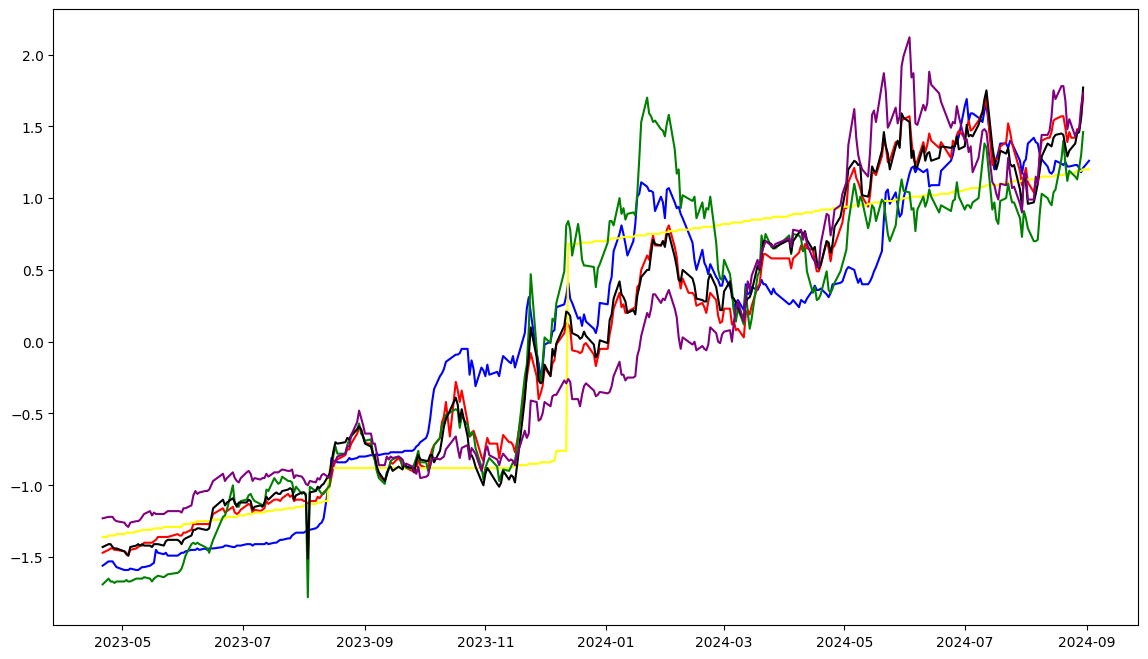

In [8]:
plt.figure(figsize=(14, 8))
plt.plot(df_dmep['FECHA'], df_dmep['CIERRE_N'], color='blue')
plt.plot(df_merval['FECHA'], df_merval['CIERRE_N'], color='red')
plt.plot(df_doficial['FECHA'], df_doficial['CIERRE_N'], color='yellow')
plt.plot(df_edn['FECHA'], df_edn['CIERRE_N'], color='green')
plt.plot(df_ypfd['FECHA'], df_ypfd['CIERRE_N'], color='black')
plt.plot(df_bbar['FECHA'], df_bbar['CIERRE_N'], color='purple')


print('Dolar Oficial: Amarillo')
print('Dolar MEP: Azul')
print('Merval: Rojo')
print('EDN: Verde')
print('YPFD: Negro')
print('BBAR: Morado')

In [9]:
labels = ['P','O','N','M','L','K', 'J', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'B', 'A']
# labels = ['G', 'F', 'E', 'D', 'C', 'B', 'A']
stoi = {ch: i for i, ch in enumerate(labels)}
itos = {i: ch for i, ch in enumerate(labels)}
# Supongamos que tienes varios DataFrames en una lista
dataframes = [df_edn[['FECHA','RESULTADO_N']], df_merval[['FECHA','RESULTADO_N']], df_dmep[['FECHA','RESULTADO_N']]]  # Lista de tus DataFrames

# Realizar el merge utilizando la columna 'FECHA' como clave, manteniendo solo la intersección
merged_df = dataframes[0]  # Iniciamos con el primer DataFrame

for i, df in enumerate(dataframes[1:], 1):
    if i == 1:
        suffix = ('', '_MERV')
    elif i == 2:
        suffix = ('', '_DMEP')
    merged_df = pd.merge(merged_df, df, on='FECHA', how='inner', suffixes=suffix)

# merged_df es el DataFrame resultante de la intersección de todos los DataFrames por 'FECHA'


In [10]:
merged_df

,FECHA,RESULTADO_N,RESULTADO_N_MERV,RESULTADO_N_DMEP
0,2023-04-21,0.11,0.13,0.66
1,2023-04-24,0.36,0.11,0.44
2,2023-04-25,-0.14,-0.03,-0.19
3,2023-04-26,-0.12,-0.09,-0.17
4,2023-04-27,-0.09,-0.38,-0.32
...,...,...,...,...
325,2024-08-26,-0.41,-0.56,0.16
326,2024-08-27,0.02,0.55,-0.21
327,2024-08-28,0.74,-0.10,-0.31
328,2024-08-29,0.89,1.13,-0.64


# seteo de los datos


In [11]:
# Función para aplicar desplazamientos
def apply_shifts(df, name, n_shifts):
    for i in range(1, n_shifts + 1):
        df[name+f'_{i}'] = df[name].shift(i)
    return df


In [12]:
len(labels)

16

In [13]:
columns_to_cut = ['RESULTADO_N', 'RESULTADO_N_MERV', 'RESULTADO_N_DMEP']
for column in columns_to_cut:
    merged_df[f'{column}_RES'] = pd.cut(merged_df[column], bins=len(labels), labels=labels)


In [14]:
context_len = 5
ind=1
for column in columns_to_cut:
  aux = merged_df.copy()
  merged_df = apply_shifts(aux, column+'_RES', context_len)

merged_df = merged_df.dropna()
merged_df.reset_index(inplace=True)
# merged_df.drop(['index'], axis=1, inplace=True)
# df.fillna('.', inplace=True)

In [15]:
merged_df.shape

(325, 23)

In [16]:
import torch

xs, ys = [], []
columns = ['RESULTADO_N_RES'+f'_{i}' for i in range(context_len, 0, -1)]
comlums = columns.extend(['RESULTADO_N_MERV_RES'+f'_{i}' for i in range(context_len, 0, -1)])
comlums = columns.extend(['RESULTADO_N_DMEP_RES'+f'_{i}' for i in range(context_len, 0, -1)])
xs = merged_df[columns]
ys = merged_df['RESULTADO_N_RES']


In [17]:
xs, ys

(    RESULTADO_N_RES_5 RESULTADO_N_RES_4 RESULTADO_N_RES_3 RESULTADO_N_RES_2  \
 0                   G                 G                 H                 H   
 1                   G                 H                 H                 H   
 2                   H                 H                 H                 H   
 3                   H                 H                 H                 H   
 4                   H                 H                 H                 H   
 ..                ...               ...               ...               ...   
 320                 D                 E                 K                 I   
 321                 E                 K                 I                 F   
 322                 K                 I                 F                 I   
 323                 I                 F                 I                 H   
 324                 F                 I                 H                 F   
 
     RESULTADO_N_RES_1 RESULTADO_N_MER

In [18]:
for column in xs.columns:
    xs.loc[:, column] = xs[column].apply(lambda x: stoi.get(x, x))  # Usar .get() para evitar errores si no se encuentra el valor
ys = ys.apply(lambda x: stoi[x])

/tmp/ipykernel_701706/2474861744.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[9, 9, 8, 8, 8, ..., 12, 11, 5, 7, 10]
Length: 325
Categories (16, int64): [0 < 1 < 2 < 3 ... 12 < 13 < 14 < 15]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  xs.loc[:, column] = xs[column].apply(lambda x: stoi.get(x, x))  # Usar .get() para evitar errores si no se encuentra el valor
/tmp/ipykernel_701706/2474861744.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[9, 8, 8, 8, 8, ..., 11, 5, 7, 10, 7]
Length: 325
Categories (16, int64): [0 < 1 < 2 < 3 ... 12 < 13 < 14 < 15]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  xs.loc[:, column] = xs[column].apply(lambda x: stoi.get(x, x))  # Usar .get() para evitar errores si no se encuentra el valor
/tmp/ipykernel_701706/2

In [19]:
xs = xs.astype(int)
ys = ys.astype(int)

In [20]:
xs, ys

(     RESULTADO_N_RES_5  RESULTADO_N_RES_4  RESULTADO_N_RES_3  \
 0                    9                  9                  8   
 1                    9                  8                  8   
 2                    8                  8                  8   
 3                    8                  8                  8   
 4                    8                  8                  8   
 ..                 ...                ...                ...   
 320                 12                 11                  5   
 321                 11                  5                  7   
 322                  5                  7                 10   
 323                  7                 10                  7   
 324                 10                  7                  8   
 
      RESULTADO_N_RES_2  RESULTADO_N_RES_1  RESULTADO_N_MERV_RES_5  \
 0                    8                  8                       9   
 1                    8                  8                       9   
 2      

In [21]:
n1 = int(.9 * len(xs))  # límite para el 90% del dataset
d = 5
xs = xs.to_numpy()
ys = ys.to_numpy()
Xtr = torch.tensor(xs[:-d])
Ytr = torch.tensor(ys[:-d])
Xdev = torch.tensor(xs[-d:])
Ydev = torch.tensor(ys[-d:])

In [22]:
Xtr, Ytr

(tensor([[ 9,  9,  8,  ...,  9,  9,  8],
         [ 9,  8,  8,  ...,  9,  8,  8],
         [ 8,  8,  8,  ...,  8,  8,  8],
         ...,
         [ 7, 10,  9,  ...,  9,  8,  9],
         [10,  9, 12,  ...,  8,  9,  9],
         [ 9, 12, 11,  ...,  9,  9,  8]]),
 tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  8,  8,  9,  8,  8,  8,  9,  8,
          8,  8,  9,  9,  9, 10,  8,  8,  9,  8,  8,  8,  8,  9,  9, 10,  8,  9,
         10,  6,  7,  8,  9,  8,  9,  9,  8,  8,  8,  8,  8, 10,  8, 10,  8,  8,
          9,  9,  8,  9,  8,  6,  9,  7,  8,  9,  8,  7,  8,  8,  8,  8,  8, 10,
         10, 10,  9,  7,  7,  9,  9,  8,  9,  9,  7,  8,  8,  9,  7,  7,  7,  7,
          7, 10,  9,  9,  9,  9,  8,  8,  9,  8,  8,  9, 10,  9,  7,  8,  8,  9,
         10, 10,  8, 10,  9,  9,  9,  8,  6, 10,  7,  7,  9,  8,  7,  6,  7, 10,
          9,  9,  7,  7,  9,  9,  8,  9,  9,  8, 10, 15, 10, 13, 15,  0,  4,  8,
          9, 10,  7, 12,  8, 11, 12, 14,  5,  7,  5, 12,  6,  6,  7,  7,  7,  5,
         

In [23]:
Xtr.shape, Ytr.shape, Xdev.shape, Ydev.shape

(torch.Size([320, 15]),
 torch.Size([320]),
 torch.Size([5, 15]),
 torch.Size([5]))

In [24]:
import torch.nn.functional as F
# MLP de nuevo...
g = torch.Generator(device='cpu').manual_seed(42)
emb_d = 7  # El número de dimensiones del Enbedding
context = context_len * len(columns_to_cut)  # el contexto se calcula por los días (context_len) para atras mas las variables involucradas (colums_to_cut).
input_size = context * emb_d  # el tamaño del input, desapilado
n_hidden = 128  # El número de neuronas en al capa hiddend que queremos

# Definición del modelo
C = torch.randn((len(labels), emb_d),         generator=g)
W1 = torch.randn((emb_d * context, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                    generator=g)
W2 = torch.randn((n_hidden, len(labels)),     generator=g)
b2 = torch.randn(len(labels),                 generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)


15744

In [25]:
train_iterations = 100000
# minibatch_size = 64
loss_log = []

for i in range(train_iterations):
    # training loop en mini batches
    # ix = torch.randint(0, len(Xtr), (minibatch_size,), generator=g)
    # Xb, Yb = Xtr[ix], Ytr[ix]
    Xb, Yb = Xtr, Ytr
    # forward pass usando F.cross_entropy
    emb = C[Xb]  # embedding de los caracteres
    embcat = emb.reshape(-1, input_size)  # embedding como una vector de input_size
    hpreact = embcat @ W1 + b1  # pre activación de la capa oculta (h)
    h = torch.tanh(hpreact)  # activación de la capa oculta (h)
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = .1 if i < 100000 else .01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10000 == 0:
        print(f'Step: {i:7d}/{train_iterations:7d} -- loss: {loss.item():.6f}')
    loss_log.append(loss.log10().item())
print(loss.item())

Step:       0/ 100000 -- loss: 20.682999
Step:   10000/ 100000 -- loss: 0.001517
Step:   20000/ 100000 -- loss: 0.000779
Step:   30000/ 100000 -- loss: 0.000532
Step:   40000/ 100000 -- loss: 0.000407
Step:   50000/ 100000 -- loss: 0.000332
Step:   60000/ 100000 -- loss: 0.000281
Step:   70000/ 100000 -- loss: 0.000243
Step:   80000/ 100000 -- loss: 0.000215
Step:   90000/ 100000 -- loss: 0.000193
0.0001749847288010642


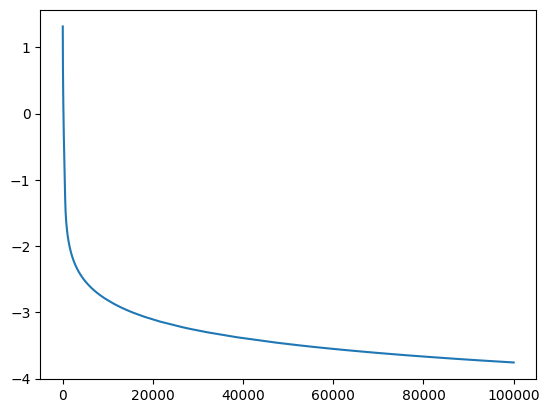

In [26]:
plt.plot(loss_log)

(array([16704.,   450.,   256.,   185.,   115.,    95.,    71.,    72.,
           53.,    41.,    46.,    49.,    40.,    43.,    42.,    36.,
           33.,    24.,    27.,    30.,    29.,    26.,    24.,    27.,
           23.,    25.,    30.,    27.,    22.,    26.,    28.,    29.,
           24.,    33.,    21.,    26.,    42.,    35.,    50.,    52.,
           48.,    66.,    83.,   101.,   106.,   137.,   153.,   256.,
          464., 20535.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

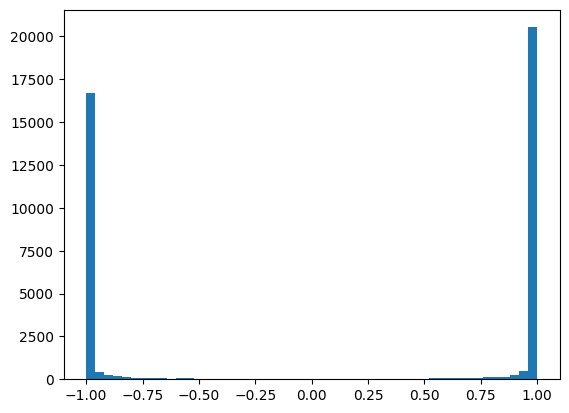

In [27]:
plt.hist(h.view(-1).tolist(),bins=50)

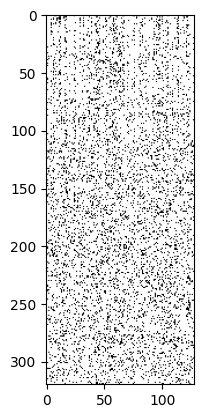

In [28]:
plt.imshow(h.abs() > 0.99, cmap='gray')

In [29]:
Xdev

tensor([[12, 11,  5,  7, 10,  9,  9,  7,  7, 10,  8,  9,  9,  8,  9],
        [11,  5,  7, 10,  7,  9,  7,  7, 10,  8,  9,  9,  8,  9,  9],
        [ 5,  7, 10,  7,  8,  7,  7, 10,  8, 10,  9,  8,  9,  9,  8],
        [ 7, 10,  7,  8, 10,  7, 10,  8, 10,  9,  8,  9,  9,  8,  8],
        [10,  7,  8, 10, 10, 10,  8, 10,  9, 11,  9,  9,  8,  8,  8]])

In [30]:
itos

{0: 'P',
 1: 'O',
 2: 'N',
 3: 'M',
 4: 'L',
 5: 'K',
 6: 'J',
 7: 'I',
 8: 'H',
 9: 'G',
 10: 'F',
 11: 'E',
 12: 'D',
 13: 'C',
 14: 'B',
 15: 'A'}

In [33]:
import random

g = torch.Generator().manual_seed(42)
ind = 0
out, outreal = [], []
for xi in Xdev:
    context = xi.tolist()
    ix = 0

    print(context)
    emb = C[torch.tensor(context)]
    h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits,dim=1)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()

    ixr = random.randint(0,len(labels)-1)

    print(itos[ix] +' -> ' + itos[Ydev[ind].item()])
    print(ix, Ydev[ind].item(), ix-Ydev[ind].item())

    print(itos[ixr] +' r-> ' + itos[Ydev[ind].item()])
    print(ixr, Ydev[ind].item(), ixr-Ydev[ind].item())
    out.append(ix)
    outreal.append(Ydev[ind].item())

    ind += 1
    print('---')


[12, 11, 5, 7, 10, 9, 9, 7, 7, 10, 8, 9, 9, 8, 9]
I -> I
7 7 0
N r-> I
2 7 -5
---
[11, 5, 7, 10, 7, 9, 7, 7, 10, 8, 9, 9, 8, 9, 9]
G -> H
9 8 1
G r-> H
9 8 1
---
[5, 7, 10, 7, 8, 7, 7, 10, 8, 10, 9, 8, 9, 9, 8]
E -> F
11 10 1
P r-> F
0 10 -10
---
[7, 10, 7, 8, 10, 7, 10, 8, 10, 9, 8, 9, 9, 8, 8]
I -> F
7 10 -3
L r-> F
4 10 -6
---
[10, 7, 8, 10, 10, 10, 8, 10, 9, 11, 9, 9, 8, 8, 8]
G -> G
9 9 0
P r-> G
0 9 -9
---


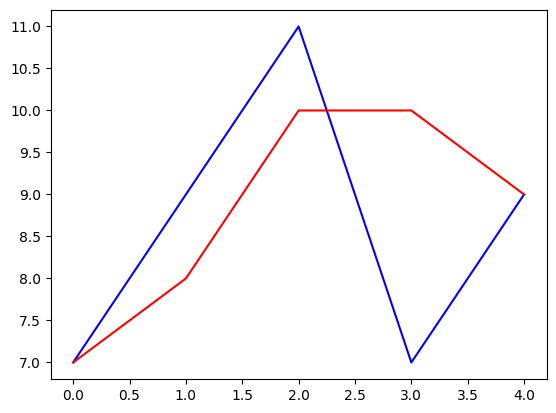

In [34]:
plt.plot(out, color='blue')
plt.plot(outreal, color='red')
plt.show()

 # Pasando en limpio y generando los métodos
 Embedding, Linear y Tanh

In [ ]:
class Embedding():
    def __init__(self, n_embeddings, embedding_dimension):
        self.weight = torch.randn((n_embeddings, embedding_dimension))

    def __call__(self, x):
        self.out = self.weight[x]
        self.out = self.out.view(self.out.shape[0], -1)
        return self.out

    def parameters(self):
        return [self.weight]


class Linear():
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out))
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class Tanh():
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [ ]:
n_hidden = 128

model = [
    Embedding(context_len, emb_d),
    Linear(input_size, n_hidden), Tanh(),
    Linear(n_hidden, context_len)
]

parameters = [p for layer in model for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True
print(f'Number of parameters: {sum((p.nelement() for p in parameters))}')

In [ ]:
Ytr

In [ ]:
train_iterations = 100000
minibatch_size = 64
loss_log = []

for i in range(train_iterations):
    # training loop en mini batches
    # ix = torch.randint(0, len(Xtr), (minibatch_size,))
    # Xb, Yb = Xtr[ix], Ytr[ix]
    # x = Xb
    x = Xtr
    # forward pass
    for layer in model:
        x = layer(x)
    loss = F.cross_entropy(x, Ytr)

    # backward pass
    for layer in model:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'Step: {i:7d}/{train_iterations:7d} -- loss: {loss.item():.6f}')
    loss_log.append(loss.log10().item())
print(loss.item())